# Graph Attention Netwotks (GAT)
## Node Classification

We will use a new popular dataset for node classification called **CiteSeer** (MIT License). Like **Cora**, it represents a network of research papers where each connection is a citation. **CiteSeer** involves **3327** nodes, whose features represent the presence (1) or absence (0) of **3703** words in a paper. The goal of this dataset is to correctly classify these nodes into six categories. Plot of **CiteSeer** made with yEd Live:

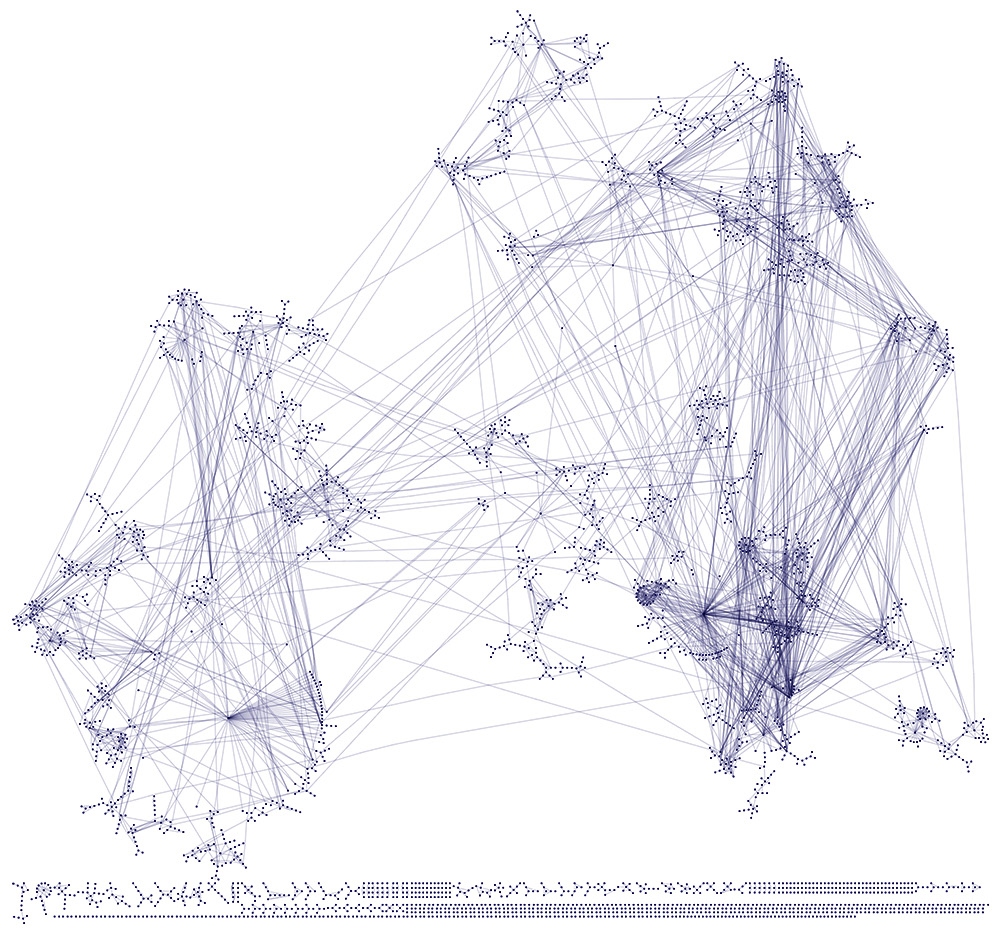

Compared to **Cora**, this dataset is larger in terms of the number of nodes (from 2,708 to 3,327) and also in terms of feature dimensionality (from 1,433 to 3,703). However, the exact same process can be applied to it:

In [1]:
import torch
!pip install -q torch-scatter~=2.1.0 torch-sparse~=0.6.16 torch-cluster~=1.6.0 torch-spline-conv~=1.2.1 torch-geometric==2.2.0 -f https://data.pyg.org/whl/torch-{torch.__version__}.html

torch.manual_seed(1)
torch.cuda.manual_seed(1)
torch.cuda.manual_seed_all(1)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 108.0/108.0 kB 1.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 210.0/210.0 kB 7.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.5/54.5 kB 2.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 565.0/565.0 kB 33.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done


We import the necessary libraries to create our own GAT class, using the GATv2 layer:

In [2]:
import torch
torch.manual_seed(1)
import torch.nn.functional as F
from torch_geometric.nn import GATv2Conv, GCNConv
from torch.nn import Linear, Dropout

import matplotlib.pyplot as plt
import numpy as np
from torch_geometric.utils import degree
from collections import Counter

from torch_geometric.datasets import Planetoid

We implement the `accuracy()` function to evaluate the performance of our model:

In [3]:
def accuracy(y_pred, y_true):
    """Calculate accuracy."""
    return torch.sum(y_pred == y_true) / len(y_true)

### Load dataset

In [4]:
dataset = Planetoid(root=".", name="CiteSeer")
data = dataset[0]
data

Processing...
Done!
/usr/local/lib/python3.10/dist-packages/torch_geometric/datasets/planetoid.py:94: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  self.data, self.slices = 

Data(x=[3327, 3703], edge_index=[2, 9104], y=[3327], train_mask=[3327], val_mask=[3327], test_mask=[3327])

### Visualizing Graph

/usr/local/lib/python3.10/dist-packages/torch_geometric/data/dataset.py:189: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  if osp.exists(f) and torch.load(f) != _repr(self.p

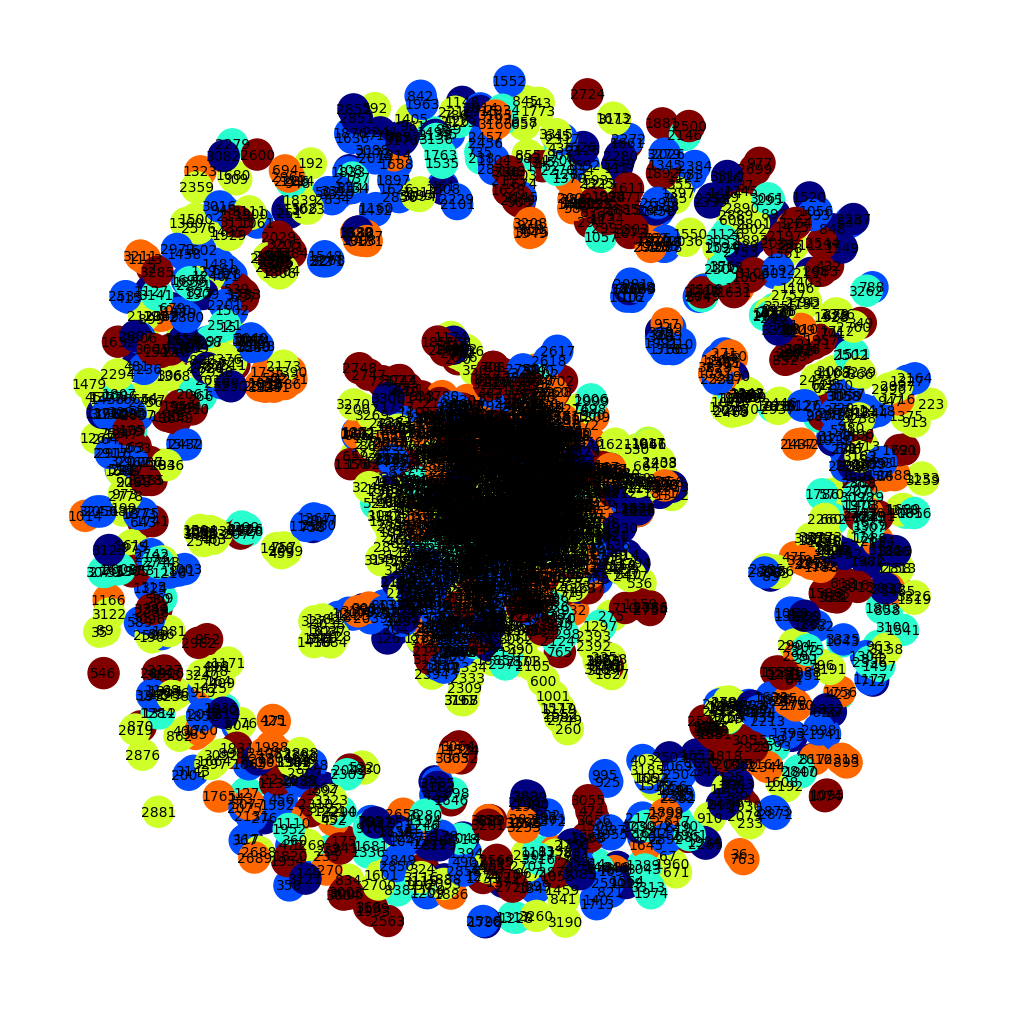

In [5]:
# plot graph...
from torch_geometric.utils import degree, to_networkx
import networkx as nx

dataset = Planetoid(root=".", name="CiteSeer")
data = dataset[0]

# Convertir a un objeto networkx
G = to_networkx(data, to_undirected=True)

# Plotear el grafo
plt.figure(figsize=(10, 10))
pos = nx.spring_layout(G)
nx.draw(G, pos, with_labels=True, node_color=data.y, cmap=plt.get_cmap('jet'), node_size=500, font_size=10)
plt.show()


For good measure, we plot the number of nodes per node degree...

<BarContainer object of 32 artists>

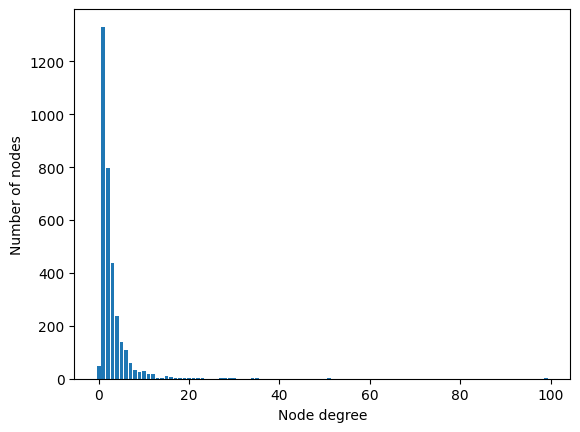

In [6]:
import matplotlib.pyplot as plt
from torch_geometric.utils import degree
from collections import Counter

# Get list of degrees for each node
degrees = degree(dataset[0].edge_index[0]).numpy()

# Count the number of nodes for each degree
numbers = Counter(degrees)

# Bar plot
fig, ax = plt.subplots()
ax.set_xlabel('Node degree')
ax.set_ylabel('Number of nodes')
plt.bar(numbers.keys(), numbers.values())

### Build GAT model

In [43]:
class GAT(torch.nn.Module):
    def __init__(self, dim_in, dim_h, dim_out, heads=8):
        super().__init__()
        self.gat1 = GATv2Conv(dim_in, dim_h, heads=heads)
        self.gat2 = GATv2Conv(dim_h*heads, dim_out, heads=1)

In [44]:
def forward(self, x, edge_index):
    h = F.dropout(x, p=0.6, training=self.training)
    h = self.gat1(h, edge_index)
    h = F.elu(h)
    h = F.dropout(h, p=0.6, training=self.training)
    h = self.gat2(h, edge_index)
    return F.log_softmax(h, dim=1)

GAT.forward = forward

In [45]:
def fit(self, data, epochs):
    criterion = torch.nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(self.parameters(), lr=0.01, weight_decay=0.01)

    self.train()
    for epoch in range(epochs+1):
        optimizer.zero_grad()
        out = self(data.x, data.edge_index)
        loss = criterion(out[data.train_mask], data.y[data.train_mask])
        acc = accuracy(out[data.train_mask].argmax(dim=1), data.y[data.train_mask])
        loss.backward()
        optimizer.step()

        if(epoch % 20 == 0):
            val_loss = criterion(out[data.val_mask], data.y[data.val_mask])
            val_acc = accuracy(out[data.val_mask].argmax(dim=1), data.y[data.val_mask])
            print(f'Epoch {epoch:>3} | Train Loss: {loss:.3f} | Train Acc: {acc*100:>5.2f}% | Val Loss: {val_loss:.2f} | Val Acc: {val_acc*100:.2f}%')

GAT.fit = fit

In [46]:
@torch.no_grad()
def test(self, data):
    self.eval()
    out = self(data.x, data.edge_index)
    acc = accuracy(out.argmax(dim=1)[data.test_mask], data.y[data.test_mask])
    return acc

GAT.test = test

In [47]:
# Create the Vanilla GNN model
gat = GAT(dataset.num_features, 32, dataset.num_classes)
print(gat)

# Train
gat.fit(data, epochs=100)

GAT(
  (gat1): GATv2Conv(3703, 32, heads=8)
  (gat2): GATv2Conv(256, 6, heads=1)
)
Epoch   0 | Train Loss: 1.794 | Train Acc: 18.74% | Val Loss: 1.79 | Val Acc: 18.35%
Epoch  20 | Train Loss: 0.614 | Train Acc: 80.16% | Val Loss: 0.86 | Val Acc: 72.33%
Epoch  40 | Train Loss: 0.555 | Train Acc: 82.11% | Val Loss: 0.83 | Val Acc: 72.18%
Epoch  60 | Train Loss: 0.555 | Train Acc: 82.21% | Val Loss: 0.88 | Val Acc: 71.28%
Epoch  80 | Train Loss: 0.555 | Train Acc: 81.36% | Val Loss: 0.87 | Val Acc: 71.13%
Epoch 100 | Train Loss: 0.571 | Train Acc: 81.71% | Val Loss: 0.87 | Val Acc: 72.33%


In [27]:
# Test
acc = gat.test(data)
print(f'GAT test accuracy: {acc*100:.2f}%')

GAT test accuracy: 77.48%


### Check hypothesis

Is it a good result? This time, we have no point of comparison.

According to Schur et al. in Pitfalls of Graph Neural Network Evaluation, the GAT is slightly better than the GCN (82.8% ± 0.6% versus 81.9% ± 0.8%) on Cora and CiteSeer (71.0 ± 0.6% versus 69.5% ± 0.9%). The authors also note that the accuracy scores are not normally distributed, making the usage of standard deviation less relevant. It is important to keep that in mind in this type of benchmark.

Previously, I speculated that poorly connected nodes might negatively impact performance. We can verify this hypothesis by plotting the average accuracy score for each node degree:

We get the model’s classifications:

In [48]:
# Get model's classifications
out = gat(data.x, data.edge_index)

We calculate the degree of each node

In [49]:
# Calculate the degree of each node
degrees = degree(data.edge_index[0]).numpy()


We store the accuracy scores and sample sizes

In [50]:
# Store accuracy scores and sample sizes
accuracies = []
sizes = []

We get the average accuracy for each node degree between zero and five using a mask with np.where():

In [51]:
# Accuracy for degrees between 0 and 5
for i in range(0, 6):
    mask = np.where(degrees == i)[0]
    accuracies.append(accuracy(out.argmax(dim=1)[mask], data.y[mask]))
    sizes.append(len(mask))

We repeat this process for every node with a degree higher than five

In [52]:
# Accuracy for degrees > 5
mask = np.where(degrees > 5)[0]
accuracies.append(accuracy(out.argmax(dim=1)[mask], data.y[mask]))
sizes.append(len(mask))

It outputs the following graph

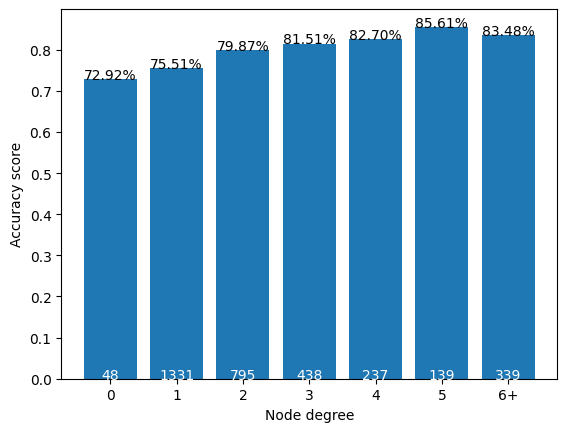

In [53]:
# Bar plot
fig, ax = plt.subplots()
ax.set_xlabel('Node degree')
ax.set_ylabel('Accuracy score')
plt.bar(['0','1','2','3','4','5','6+'], accuracies)
for i in range(0, 7):
    plt.text(i, accuracies[i], f'{accuracies[i]*100:.2f}%', ha='center', color='black')
for i in range(0, 7):
    plt.text(i, accuracies[i]//2, sizes[i], ha='center', color='white')

Our result must be like this:

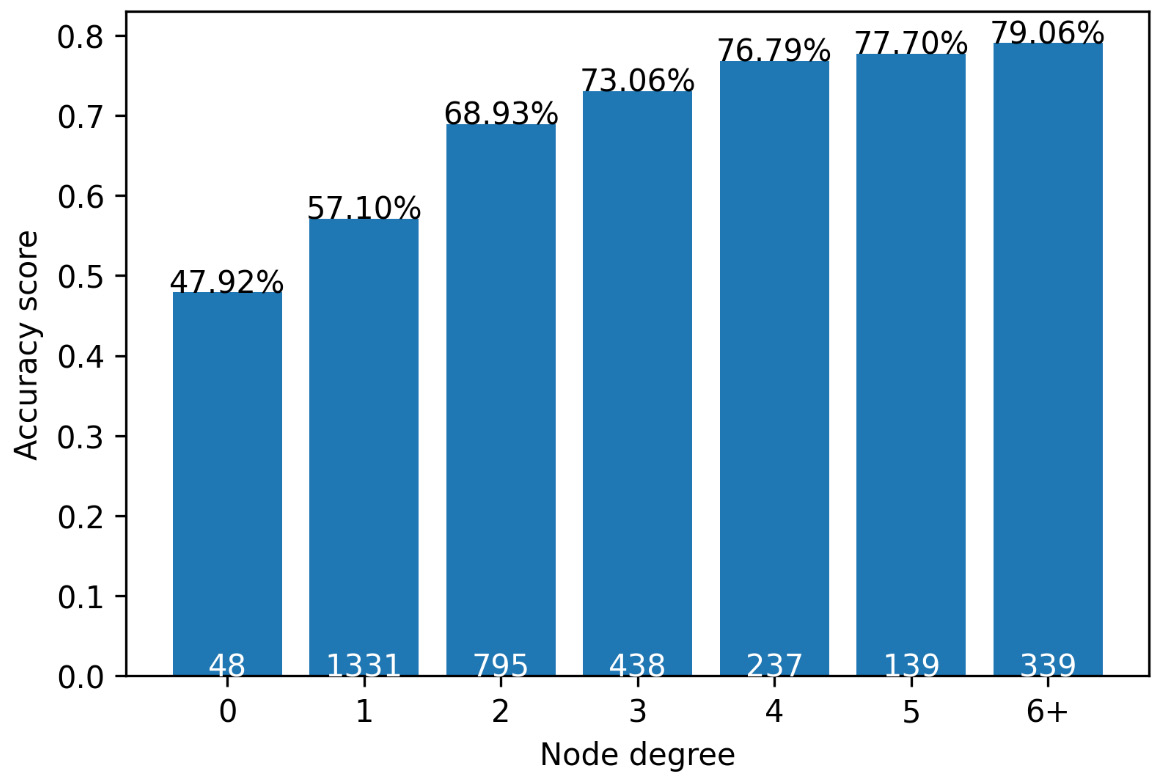

Confirms our hypothesis: nodes with few neighbors are harder to classify correctly. Furthermore, it even shows that, in general, the higher the node degree, the better the accuracy score. This is quite natural because a higher number of neighbors will provide more information to the GNN to make its predictions.